In [1]:
import torch, pickle, time, os, random
from sklearn.model_selection import train_test_split
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device

torch.manual_seed(42)
random.seed(42)

In [77]:
sum((ys-np.mean(ys))**2)*100**2/len(ys)

array([154.45163], dtype=float32)

In [2]:
os.listdir(osp.expanduser('~/../../../scratch/gpfs/cj1223/GraphStorage/'))

['vlarge_all_4t_z1.0_standard_quant',
 'vlarge_4t_quantile_raw_redshift_75_all',
 'vlarge_all_4t_z1.0_quantile_raw',
 'vlarge_all_4t_z2.0_standard_quant',
 'vlarge_all_4t_z2.0_None',
 'redshift_scan_0',
 'testid_all_4t_z2.0_None',
 'vlarge_all_4t_z0.0_quantile_stand',
 'vlarge_all_multi_try1',
 'vlarge_4t_quantile_raw_redshift_99_all',
 'vlarge_all_4t_z2.0_quantile_raw',
 'vlarge_all_4t_z0.0_standard_quant',
 'vlarge_all_4t_z0.5_quantile_quant',
 'vlarge_4t_quantile_raw_redshift_50_all',
 'vlarge_all_4t_z2.0_quantile_stand',
 'vlarge_all_4t_z1.0_quantile_quant',
 'transformers',
 'vlarge_all_4t_z0.0_standard_raw',
 'vlarge_all_4t_z0.5_standard_stand',
 'vlarge_all_4t_z0.5_standard_quant',
 'vlarge_all_4t_z0.0_quantile_raw',
 'old',
 'vlarge_all_4t_z1.0_None',
 'vlarge_all_4t_z1.0_standard_stand',
 'vlarge_all_4t_z2.0_standard_raw',
 'vlarge_4t_quantile_raw_redshift_95_all',
 'testid_all_4t_z0.0_None',
 'vlarge_all_4t_z0.5_standard_raw',
 'vlarge_all_4t_z0.0_None',
 'vlarge_4t_quantile_

In [37]:
case='vlarge_all_smass_z0.0_quantile_quant'
case='vlarge_all_smass'
case='vlarge_all_4t_z0.0_standard_raw'


datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

In [39]:
from torch_geometric.data import Data
data=[]
for d in datat:
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=10**d.y[[0]]/100))

In [40]:
datat=0

In [41]:
try:
    n_targ=len(data[0].y)
except:
    n_targ=1
n_feat=len(data[0].x[0])
n_feat

43

In [42]:
from torch import nn
class MLP(nn.Module):
    def __init__(self, n_in, n_out, hidden=64, nlayers=2, layer_norm=True):
        super().__init__()
        layers = [nn.Linear(n_in, hidden), nn.ReLU()]
        for i in range(nlayers):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.ReLU()) 
        if layer_norm:
            layers.append(nn.LayerNorm(hidden))
        layers.append(nn.Linear(hidden, n_out))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [43]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        self.node_enc = MLP(n_feat, hidden_channels, layer_norm=True)
        
        self.conv1 = SAGEConv(hidden_channels, hidden_channels) 
        
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        
        self.lin = Linear(2*hidden_channels, hidden_channels)
        self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin_f = Linear(hidden_channels, n_targ)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.node_enc(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)
        x = x.relu()
#         x = global_add_pool(x, batch)
        x = torch.cat([global_max_pool(x, batch),global_add_pool(x, batch)], 1)  ## Miles says use sumpool

        x = self.lin(x)
        x = self.lin_f(self.norm(x))
#         x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=64)
next(model.parameters()).is_cuda ##check number one

False

In [44]:
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
# criterion = torch.nn.SmoothL1Loss(beta=0.3)


n_epochs=100
n_trials=1
batch_size=128
split=0.8
# test_data=data[int(len(data)*split):]
# train_data=data[:int(len(data)*split)]
train_data, test_data=train_test_split(data, test_size=0.2)

l1_lambda = 1e-5
l2_lambda = 0

In [45]:
trains, tests, scatter = [], [], []
yss, preds=[],[]
model = GCN(hidden_channels=80)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0,num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
print('GPU ', next(model.parameters()).is_cuda)
# Initialize our train function
def train():
    model.train()
    
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,n_targ)) 
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
#             loss.backward()
        accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
#     print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []
    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out = model(dat.x, dat.edge_index, dat.batch) 
            ys.append(dat.y.view(-1,n_targ))
            outs.append(out)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    return torch.std(outss - yss, axis=0), outss, yss

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


GPU  True


In [56]:
#this uses about 1 GB of memory on the GPU
tr_acc, te_acc = [], []
start=time.time()
for epoch in range(n_epochs):

    train()

    if (epoch+1)%2==0:
        train_acc, _ , _ = test(train_loader)
        test_acc, _ , _ = test(test_loader)
        tr_acc.append(train_acc.cpu().numpy())
        te_acc.append(test_acc.cpu().numpy())
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu().numpy(), 4)} \n \
        Test scatter: {np.round(test_acc.cpu().numpy(), 4)}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 002, Train scatter: [0.0731] 
         Test scatter: [0.0765]
Epoch: 004, Train scatter: [0.0674] 
         Test scatter: [0.0682]
Epoch: 006, Train scatter: [0.0632] 
         Test scatter: [0.0647]


KeyboardInterrupt: 

In [57]:
print(f'{np.round(train_acc.cpu().numpy(), 4)}')

[0.0632]


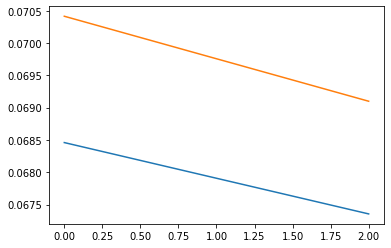

In [58]:
from scipy.ndimage import gaussian_filter as gf
plt.plot(gf(np.array(tr_acc), 2))
plt.plot(gf(np.array(te_acc), 2))

In [86]:
teststd, outtest, ytest = test(test_loader)
pred=outtest.cpu().numpy()*100
ys=ytest.cpu().numpy()*100

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [87]:
from sklearn.metrics import r2_score
r2_score(ys, pred)

0.6397235302621864

In [88]:
(np.std(ys-pred)**2/np.std(ys-np.mean(ys))**2)**(-1), np.std(ys-pred)**2, np.std(ys-np.mean(ys))**2*1

(2.8170165597020715, 54.830320641712206, 154.4579212214776)

In [106]:
mask=ys<100/0.7

In [107]:
mask

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [108]:
(sum((ys[mask]-np.mean(ys[mask]))**2))/(sum((ys[mask]-pred[mask])**2)), (sum((ys[mask]-np.mean(ys[mask]))**2))/len(ys[mask]), (sum((ys[mask]-pred[mask])**2))/len(ys[mask])

(2.0786795027146345, 100.75181349721699, 48.46914272529314)

In [ ]:
ys

In [62]:
np.std(10**(ys)-10**(pred))**2, np.std(10**(ys)-10**(np.mean(ys)))**2

(845.5789506186884, 861.3859114145307)

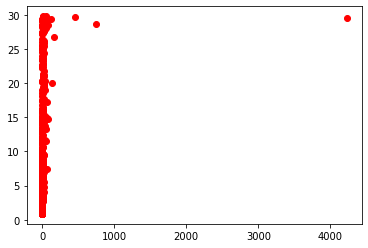

In [63]:
plt.plot(10**(ys), 10**(pred), 'ro')

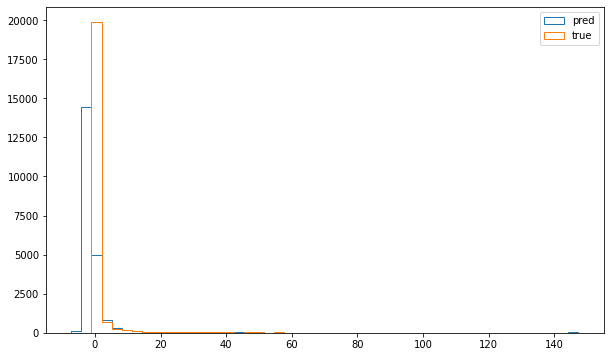

In [93]:
fig , ax = plt.subplots(1, figsize=(10,6))
l=0
for k in range(n_targ):
#     ax[k].hist(outtest.cpu().numpy()[:,k]-ytest.cpu().numpy()[:,k], bins=1000, histtype='step', label='res')
    ax.hist(pred[:,k], bins=50, range=list(np.percentile(pred[:,k], [l,100-l])), histtype='step', label='pred')
    ax.hist(ys[:,k], bins=50, range=list(np.percentile(pred[:,k], [l,100-l])),histtype='step', label='true')
    ax.legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))

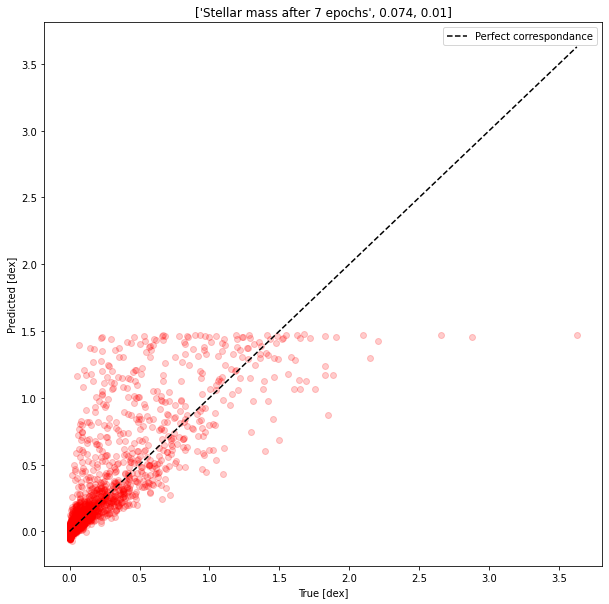

In [65]:
fig , ax = plt.subplots(1,1, figsize=(10,10))
yte=ys
predte=pred
ax.plot(yte, predte, 'ro', alpha=0.2)
ax.plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
ax.set(title=[f'Stellar mass after {epoch} epochs', np.round(np.std(yte-predte),3), np.round(np.mean(yte-predte),2)], xlabel='True [dex]', ylabel='Predicted [dex]')
ax.legend()

In [14]:
transform='quantile'
transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_alltarg_1.pkl")
target_scaler=pickle.load(open(transform_path, 'rb'))

transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat_1.pkl")
feat_scaler=pickle.load(open(transform_path, 'rb'))

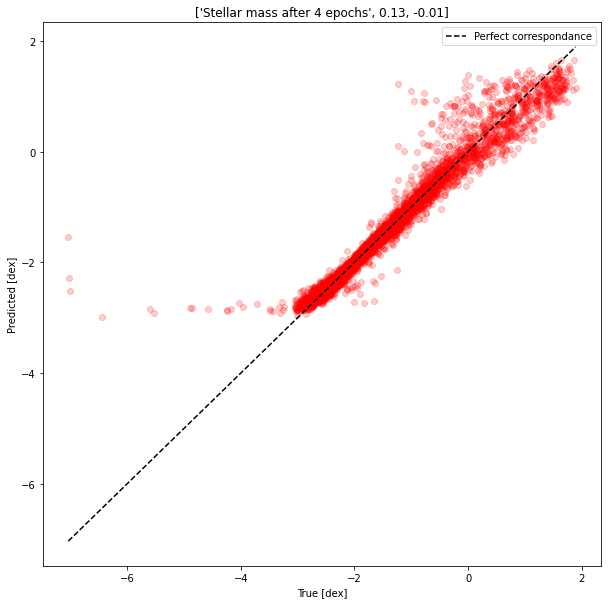

In [15]:
fig , ax = plt.subplots(1,1, figsize=(10,10))
yte=np.hstack(target_scaler[8].inverse_transform(ys.reshape(-1,1)))
predte=np.hstack(target_scaler[8].inverse_transform(pred.reshape(-1,1)))
ax.plot(yte, predte, 'ro', alpha=0.2)
ax.plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
ax.set(title=[f'Stellar mass after {epoch} epochs', np.round(np.std(yte-predte),2), np.round(np.mean(yte-predte),2)], xlabel='True [dex]', ylabel='Predicted [dex]')
ax.legend()